# Overview
This notebook is intended to demonstrate the _quarter-five spot_ problem (see e.g. https://users.wpi.edu/~sweekes/GEO/fivespot.html).

In simple terms, consider a domain with no-flow boundary (all neumann = 0). Let the lower-left corner be an injection well ($f=1$ in that cell) and the upper-right corner be a production well ($f=-1$ in that cell).

The governing equation and setup is described below.

## Setup
Let's setup the problem.

Recall, our aim is to solve single-phase flow,
$$-\nabla\cdot K \nabla p = f$$
over the domain $\Omega$. 

The boundary conditions will be defined over $\partial\Omega$, and are mathematically written as
$$p=p_b, \quad -K\nabla p \cdot \mathbf{n} = u_b$$
for Dirichlet ($\partial\Omega_d$) and Neumann ($\partial\Omega_n$) conditions respectively.

$f$ is a scalar source/sink term. $K$ is the permeability matrix. $p_b$ is the pressure at the boundary (Dirichlet), $u_b$ is the flux at the boundary (Neumann).

The basic setup is:
$$
\Omega = [0,1]^2, \quad 
\partial \Omega_n = \partial\Omega,\quad 
\partial \Omega_d = \emptyset 
$$

with data: 
$$
f=0, \quad
K=1
\quad 
\text{ and }\quad  
u_b=0
$$
And $f=1$ at the origin and $f=-1$ at $(1,1)$

In [1]:
# Imports
import numpy as np
import scipy.sparse as sps
import porepy as pp

In [2]:
# Setup grid
Nx = Ny = 32
g = pp.CartGrid([Nx,Ny], [1,1])
g.compute_geometry()

In [3]:
# Boundary conditions
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]

labels = np.array(['neu']*b_faces.size) #Neumann everywhere

# For testing, try dirichlet everywhere
#labels = np.array(['dir']*b_faces.size)
#bc_val = np.ones(g.num_faces)

# For testing, try dirichlet bottom and top
#labels[g.face_centers[1, b_faces] == 0.] = 'dir'
#labels[g.face_centers[1, b_faces] == 1.] = 'dir'


bc = pp.BoundaryCondition(g, b_faces, labels)

bc_val = np.zeros(g.num_faces) #no-flow condition


# For testing dirichlet bottom and top to -1 and 1
#bottom = b_faces[g.face_centers[1, b_faces] == 0.]
#top = b_faces[g.face_centers[1, b_faces] == 1.]
#bc_val[bottom] = np.zeros(bottom.size)
#bc_val[top] = np.ones(top.size)

In [4]:
# Permeability
perm = pp.SecondOrderTensor(np.ones(g.num_cells))

# source
f = np.zeros(g.num_cells)
#f=g.cell_volumes

# Injection in lower-left corner. Production upper-right
f[[0, -1]] = [1, -1]

In [5]:
# Build problem
specified_parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}
data = pp.initialize_default_data(g, {}, "flow", specified_parameters)

In [6]:
# Problem solution
solver = pp.Tpfa("flow")
solver.discretize(g, data)
A, b = solver.assemble_matrix_rhs(g, data)
p = sps.linalg.spsolve(A, b)

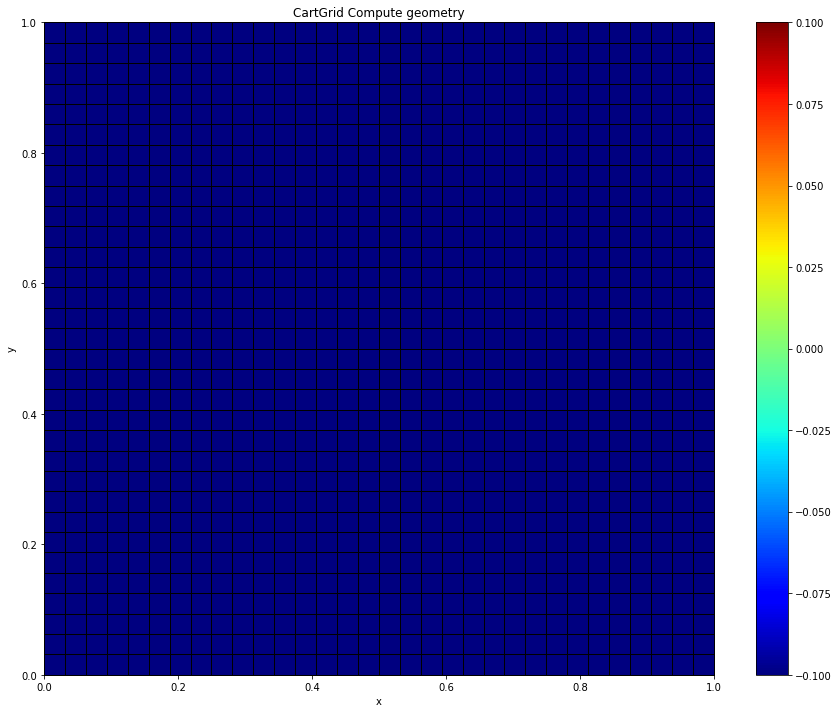

In [7]:
# Visualization
pp.plot_grid(g, p, figsize=(15, 12), plot_2d=True)